In [1]:
import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
num_dfs = 40
dfs = []
for i in range(num_dfs):
    dfs.append(pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/jan_17_50events_{i}.csv"))
data = pd.concat(dfs)

In [ ]:
def process_df(df, cone_angle_deg=45):
    modified_df = df.copy()
    event_references = modified_df.groupby('event_idx').last()[['first hit x', 'first hit y']]
    modified_df['ModifiedTrueID'] = modified_df['trueID']
    
    for event_id in modified_df['event_idx'].unique():
        event_mask = modified_df['event_idx'] == event_id
        event_data = modified_df[event_mask]
        
        ref_x = event_references.loc[event_id, 'first hit x']
        ref_y = event_references.loc[event_id, 'first hit y']
        reference_angle = np.degrees(np.arctan2(ref_x, ref_y))
        hit_angles = np.degrees(np.arctan2(event_data['strip_x']*10, event_data['strip_y']*10))
        # Get the angular distance from the reference direction
        angles = np.abs(hit_angles - reference_angle)
        # Handle the wraparound at ±180 degrees
        angles = np.minimum(angles, 360 - angles)
        
        # Modify TrueID for points outside cone
        modified_df.loc[event_mask & (angles > cone_angle_deg), 'ModifiedTrueID'] = -1
    return modified_df

# Plot the data
# modified_df = process_df(data, cone_angle_deg = 22)

In [3]:
class HitDataset(DGLDataset):
    def __init__(self, data, filter_events,max_distance = 500):
        self.data = data
        self.filter_events = filter_events
        self.max_distance = 500
        super().__init__(name = "KLM_reco")
    def process(self):
        events_group = self.data.groupby("event_idx")
        self.labels = torch.empty(len(events_group))
        self.graphs = []
        it_idx = 0
        for event_idx in events_group.groups:
            curr_event = events_group.get_group(event_idx)
            nhits = len(curr_event)
            '''FIRST FILTER FOR EVENTS'''
            if(self.filter_events):
                ModifiedTrueID_unique = np.array(curr_event['ModifiedTrueID'].unique())
                valid_ModifiedTrueID_unique = ModifiedTrueID_unique[ModifiedTrueID_unique != -1]
                #skip events with multiple valid trueIDs
                if(len(valid_ModifiedTrueID_unique) > 1):
                    continue
            
                #skip events with no valid ModififiedTrueIDs
                if(len(valid_ModifiedTrueID_unique) == 0):
                    continue
            #Fully connected network of hits
            if(nhits <2):
                sources, destinations = [],[]
            else:
                x = curr_event['strip_x'].values
                y = curr_event['strip_y'].values

                # Create coordinate matrices
                x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
                y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences

                # Compute distances in one go
                distances = np.sqrt(x_diff**2 + y_diff**2)

                # Create mask for valid edges (upper triangle only to avoid duplicates)
                upper_mask = (distances < self.max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)

                # Get edge indices for upper triangle
                src_upper, dst_upper = np.where(upper_mask)

                # Create the bidirectional edges
                sources = np.concatenate([src_upper, dst_upper])
                destinations = np.concatenate([dst_upper, src_upper])
            g = dgl.graph((sources, destinations), num_nodes=nhits)

            if(nhits < 2):
                g = dgl.add_self_loop(g)
            #Want to predict momentum/energy
            label = torch.tensor(curr_event["P"].to_numpy()[0])
            self.labels[it_idx] = label

            #Node features: strip position and SiPM output

            
            '''TO RETAIN STRUCTURE OF FEATURES:'''
            '''
            #strip_pos has shape nhits x 2
            strip_pos = torch.tensor(np.stack((curr_event["strip_x"].to_numpy(),curr_event["strip_y"].to_numpy()),axis = 1))
            #SiPM_timing has shape nhits x 2 (SiPMs are together in one tensor)
            SiPM_timing = torch.tensor(curr_event["Time"])
            SiPM_charge = torch.tensor(curr_event["Charge"])
           
            g.ndata["features"] = torch.stack((strip_pos,SiPM_timing,SiPM_charge),dim=1)
            '''
            '''FLATTENED VERSION'''
            #THIS VERSION KEEPS FEATURES IN ONE DIMENSION
            feats = np.stack((
                curr_event["strip_x"].to_numpy(),curr_event["strip_y"].to_numpy(),
                curr_event["Time"].to_numpy(),
                curr_event["Charge"].to_numpy()
            ),axis = -1)
            g.ndata["features"] = torch.tensor(feats)
    

            #add graph to dataset
            self.graphs.append(g)
            it_idx += 1
        self.dim_nfeats = self.graphs[0].ndata["features"].shape[1]

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)


    
def test_process(data,max_distance = 500):
    events_group = data.groupby("event_idx")
    labels = torch.empty(len(events_group))
    graphs = []
    it_idx = 0
    for event_idx in events_group.groups:
        curr_event = events_group.get_group(event_idx)
        nhits = len(curr_event)
        #Fully connected network of hits
        if(nhits <2):
            sources, destinations = [],[]
        else:
            # Convert coordinates to numpy arrays for faster computation
            x = curr_event['strip_x'].values
            y = curr_event['strip_y'].values

            # Create coordinate matrices
            x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
            y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences

            # Compute distances in one go
            distances = np.sqrt(x_diff**2 + y_diff**2)

            # Create mask for valid edges (upper triangle only to avoid duplicates)
            upper_mask = (distances < max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)

            # Get edge indices for upper triangle
            src_upper, dst_upper = np.where(upper_mask)

            # Create the bidirectional edges
            sources = np.concatenate([src_upper, dst_upper])
            destinations = np.concatenate([dst_upper, src_upper])
            '''
            sources = []
            destinations = []

            for i in range(nhits):
                for j in range(i+1, nhits):
                    distance = np.sqrt((curr_event.iloc[i]["strip_y"] - curr_event.iloc[j]["strip_y"])**2+(curr_event.iloc[i]["strip_x"] - curr_event.iloc[j]["strip_x"])**2)
                    if distance < max_distance:
                        sources.extend([i,j])
                        destinations.extend([j,i])
            '''
        g = dgl.graph((sources, destinations), num_nodes=nhits)

        if(nhits < 2):
            g = dgl.add_self_loop(g)
        #Want to predict momentum/energy
        label = torch.tensor(curr_event["P"].to_numpy()[0])
        labels[it_idx] = label
        
        #THIS VERSION KEEPS FEATURES IN ONE DIMENSION
        feats = np.stack((
            curr_event["strip_x"].to_numpy(),curr_event["strip_y"].to_numpy(),
            curr_event["Time"].to_numpy(),
            curr_event["Charge"].to_numpy()
        ),axis = -1)
        g.ndata["features"] = torch.tensor(feats)


        #add graph to dataset
        graphs.append(g)
        it_idx += 1
    dim_nfeats = graphs[0].ndata["features"].shape[1]
    return graphs,labels, dim_nfeats

In [3]:
dataset = HitDataset(data,False)
print("done")

In [52]:
from line_profiler import LineProfiler

profiler = LineProfiler()
profiler.add_function(test_process)
# profiler.add_function(processor.generate_waveform)
profiler.run('test_process(data)')
profiler.print_stats()
# with open('profiling/Analyze_dev/profile_stats_w_waveform_jan_16_10events.txt', 'w') as f:
#     profiler.print_stats(stream=f)

Timer unit: 1e-09 s

Total time: 27.9476 s
File: /tmp/ipykernel_3906785/454835452.py
Function: test_process at line 77

Line #      Hits         Time  Per Hit   % Time  Line Contents
    77                                           def test_process(data,max_distance = 500):
    78         1     796468.0 796468.0      0.0      events_group = data.groupby("event_idx")
    79         1    5041117.0    5e+06      0.0      labels = torch.empty(len(events_group))
    80         1        348.0    348.0      0.0      graphs = []
    81         1        182.0    182.0      0.0      it_idx = 0
    82        51      50322.0    986.7      0.0      for event_idx in events_group.groups:
    83        50   33135799.0 662716.0      0.1          curr_event = events_group.get_group(event_idx)
    84        50     156471.0   3129.4      0.0          nhits = len(curr_event)
    85                                                   #Fully connected network of hits
    86        50      16902.0    338.0     

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def create_fast_edge_lists(curr_event, max_distance):
    # Convert coordinates to numpy arrays for faster computation
    x = curr_event['strip_x'].values
    y = curr_event['strip_y'].values
    
    # Create coordinate matrices
    x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
    y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences
    
    # Compute distances in one go
    distances = np.sqrt(x_diff**2 + y_diff**2)
    
    # Create mask for valid edges (upper triangle only to avoid duplicates)
    upper_mask = (distances < max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)
    
    # Get edge indices for upper triangle
    src_upper, dst_upper = np.where(upper_mask)
    
    # Create the bidirectional edges
    sources = np.concatenate([src_upper, dst_upper])
    destinations = np.concatenate([dst_upper, src_upper])
    
    return sources, destinations

def visualize_detector_graph(curr_event, sources, destinations, max_edges=1000, figsize=(10, 10)):
    """
    Visualizes the detector hits and their connections.
    
    Parameters:
    curr_event (pd.DataFrame): DataFrame containing 'strip_x' and 'strip_y' columns
    sources (np.array): Array of source node indices
    destinations (np.array): Array of destination node indices
    max_edges (int): Maximum number of edges to plot to avoid overcrowding
    figsize (tuple): Figure size in inches
    """
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot nodes (hits)
    plt.scatter(curr_event['strip_x'], curr_event['strip_y'], 
               c='blue', s=50, alpha=0.6, label='Detector hits')
    
    # If there are too many edges, randomly sample them
    n_edges = len(sources)
    if n_edges > max_edges:
        idx = np.random.choice(n_edges, max_edges, replace=False)
        sources = sources[idx]
        destinations = destinations[idx]
    
    # Plot edges
    for src, dst in zip(sources, destinations):
        x1, y1 = curr_event.iloc[src][['strip_x', 'strip_y']]
        x2, y2 = curr_event.iloc[dst][['strip_x', 'strip_y']]
        plt.plot([x1, x2], [y1, y2], 'gray', alpha=0.1, linewidth=0.5)
    
    # Add labels and title
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Detector Graph Visualization\n{len(curr_event)} nodes, {n_edges//2} edges')
    
    # Add text with statistics
    stats_text = f'Total nodes: {len(curr_event)}\n'
    stats_text += f'Total edges: {n_edges//2}\n'  # Divide by 2 because edges are bidirectional
    stats_text += f'Average degree: {n_edges/len(curr_event):.1f}'
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    
    return plt.gcf()


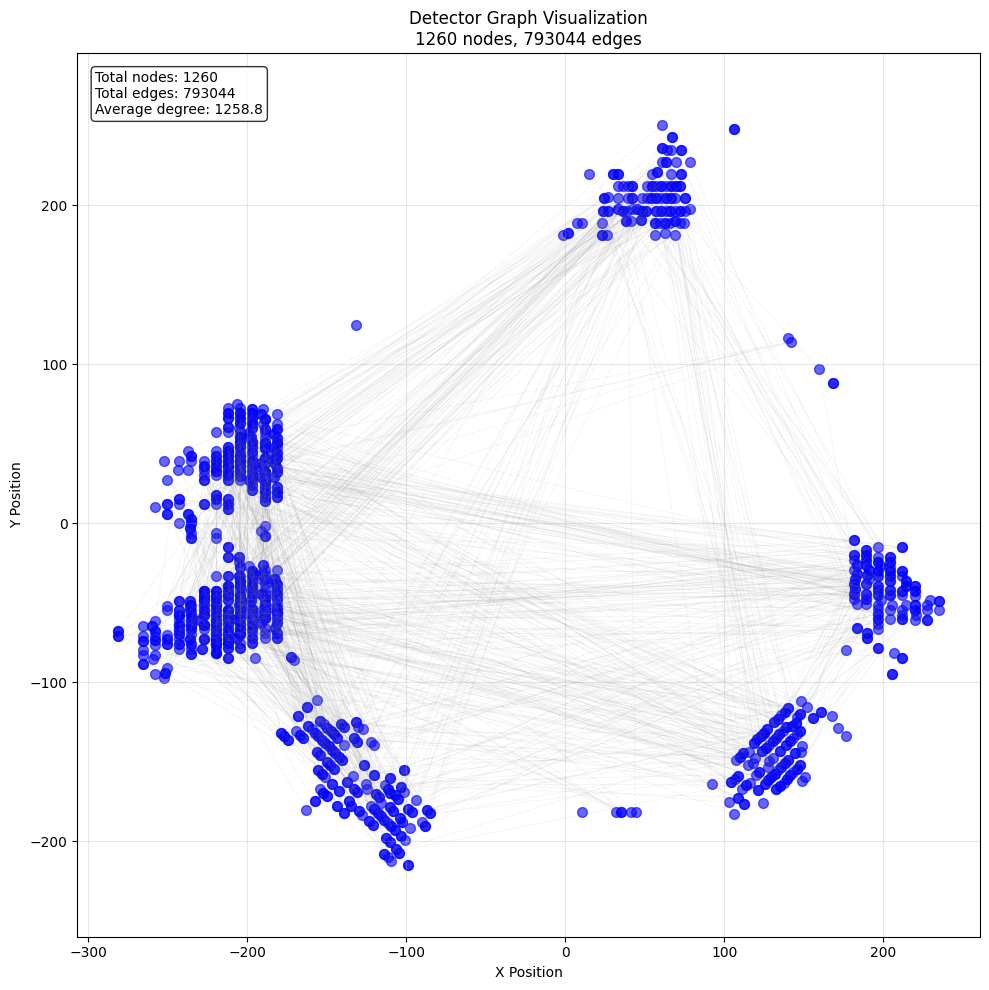

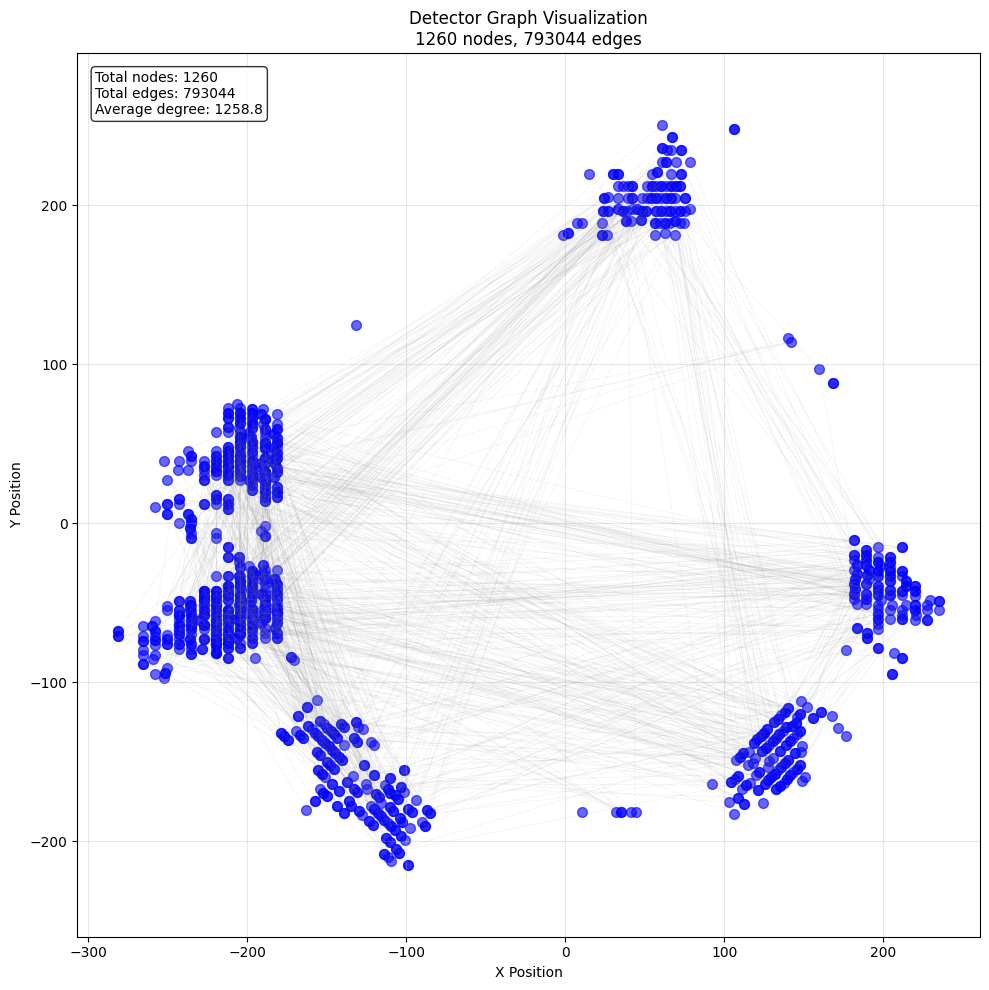

In [15]:
event_groups = data.groupby("event_idx")
event_1 = event_groups.get_group(5)
srcs, dests = create_fast_edge_lists(event_1,500)
visualize_detector_graph(event_1,srcs,dests)

In [ ]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes = 1):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")

In [ ]:
dataset[0][0]

In [110]:
# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [111]:
test_frac = 0.8
test_start = int(np.floor(len(dataset) * 0.8))
train_dataset = dataset[0:test_start]
test_dataset = dataset[test_start:]

In [117]:
criterion = nn.MSELoss()
n_epochs = 30
losses = []
for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for graph_idx in range(len(train_dataset[0])):
        try:
            graph = train_dataset[0][graph_idx]
            label = train_dataset[1][graph_idx]
            pred = model(graph, graph.ndata["features"].float())
            loss = criterion(pred.squeeze(0), label.unsqueeze(-1))
            epoch_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        except:
            print(graph)
    losses.append(np.mean(epoch_losses))

100%|██████████| 30/30 [00:02<00:00, 10.27it/s]


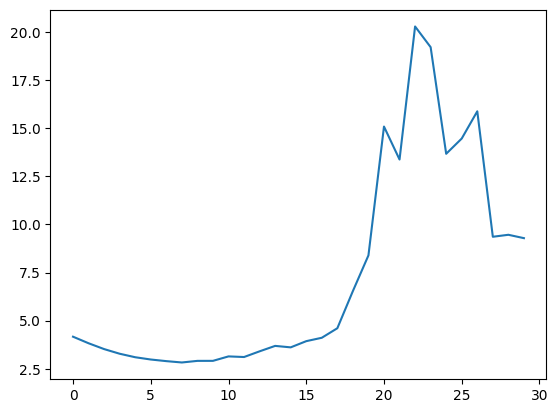

In [118]:
plot.plot(losses)

In [119]:
truths = []
preds = []
sqerrors = []
for graph_idx in range(len(test_dataset[0])):
    graph = test_dataset[0][graph_idx]
    truth = test_dataset[1][graph_idx].detach()
    pred = model(graph, graph.ndata["features"].float()).detach()
    truths.append(truth)
    preds.append(pred)
    sqerrors = pow(truth - pred,2)
sqerrors = np.array(sqerrors)
rmse = np.sqrt(np.mean(sqerrors))

In [120]:
rmse

np.float32(0.602939)

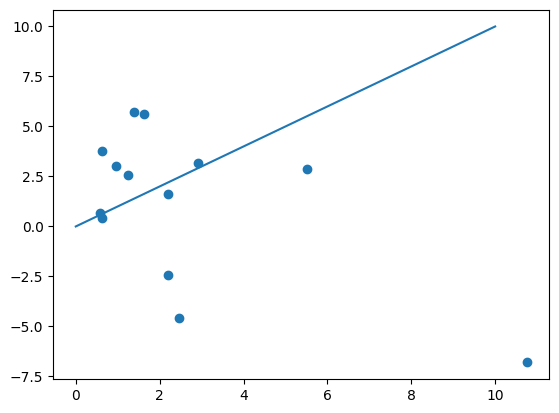

In [121]:
plot.scatter(truths,preds)
plot.plot([0,10],[0,10])